In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 12)

from tqdm import tqdm

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['date'], index_col=['date'])
list(train)

['store', 'item', 'sales']

In [3]:
test = pd.read_csv('data/test.csv', parse_dates=['date'], index_col=['date'])
test.shape

(45000, 3)

In [ ]:
test.head()

The test set asks for 90 days of forecast.  Therefore, the holdout set should also have 90 days worth of data.  Also, there are 10 stores with 50 items.

In [9]:
sample = pd.read_csv('data/sample_submission.csv')
sample.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [ ]:
plt.plot(train.item, train.sales)

In [ ]:
def dumb_prediction(train, test, submission):
    for _, row in tqdm(test.iterrows()):
        item, store = row['item'], row['store']
        day, month = row.name.day, row.name.month
        itemandstore = (train.item == item) & (train.store == store)
        dayandmonth = (train.index.month == month) & (train.index.day == day)
        train_rows = train.loc[itemandstore & dayandmonth]
        pred_sales = int(round(train_rows.mean()['sales']))
        submission.at[row['id'], 'sales'] = pred_sales
    return submission

In [ ]:
dumb_prediction(train, test, sample).head()

In [ ]:
train.index.dayofweek

<h2>Data Exploration</h2>

In [4]:
def expand_df(df):
    data = df.copy()
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['DoW'] = data.index.dayofweek
    return data

data = expand_df(train)
display(data)

grand_avg = data.sales.mean()
print("The grand average of sales in this dataset is {0:.4f}".format(grand_avg))

,store,item,sales,day,month,year,DoW
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5
2013-01-06,1,1,12,6,1,2013,6
...,...,...,...,...,...,...,...
2017-12-26,10,50,41,26,12,2017,1
2017-12-27,10,50,63,27,12,2017,2


The grand average of sales in this dataset is 52.2503


<h3>Changes by year</h3>

In [ ]:
# Pivot table is a summary of the data, using index as rows, columns as columns,
#   and applying aggfunc to the values
agg_year_item = pd.pivot_table(data, values='sales', index='year',
                               columns='item', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(data, values='sales', index='year',
                               columns='store', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")

plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()

All items and stores seem to enjoy a similar growth in sales over the years.

<h3>Changes by month</h3>

In [ ]:
agg_month_item = pd.pivot_table(data, values='sales', index='month',
                               columns='item', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(data, values='sales', index='month',
                                columns='store', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")

plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()

All items and stores seem to share a common pattern in sales over months as well.

<h3>Changes by day of the week</h3>

In [ ]:
agg_month_item = pd.pivot_table(data, values='sales', index='DoW',
                               columns='item', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(data, values='sales', index='DoW',
                                columns='store', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")

plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

All items and stores also seem to share a common pattern in sales over the days of the week.

<h3>Are these patterns degenerate?</h3>

This is an important question.  Not checking for degeneracies in the data can lead to missing important trends in complex datasets.  For example, when looking at the monthly patterns, we average over all days of the month, years and either items or stores.  But what if sales have a multi-dimensional dependence on two of these parameters that isn't easily separable?  So, always check for degeneracies in the data!

In [ ]:
agg_dow_month = pd.pivot_table(data, values='sales', index='DoW',
                              columns='month', aggfunc=np.mean).values
agg_month_year = pd.pivot_table(data, values='sales', index='month',
                               columns='year', aggfunc=np.mean).values
agg_dow_year = pd.pivot_table(data, values='sales', index='DoW',
                             columns='year', aggfunc=np.mean).values

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(agg_dow_month / agg_dow_month.mean(0)[np.newaxis])
plt.title("Months")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")

plt.subplot(132)
plt.plot(agg_month_year / agg_month_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Months")
plt.ylabel("Relative Sales")

plt.subplot(133)
plt.plot(agg_dow_year / agg_dow_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")

plt.show()

In this case, however, there don't seem to be any sneaky degeneracies.  We can effectively treat the "month, "year", "day of the week", "item" and "store" as completely independent modifiers to sales predictions.  This leads to a <i>very very simple</i> prediction model.

"Relative sales" in the plots above are the sales relative to the average.  Since there are very regular patterns in the "month, "day of the week", and "year" trends, all we have to do is simply memorize these trends and apply them to our predictions by multiplying them to the expected average sales.  We get the expected average sales for an item at a store from the historical numbers in the training set.

<h3>Item-Store relationship</h3>

In [ ]:
agg_store_item = pd.pivot_table(data, values='sales', index='store',
                               columns='item', aggfunc=np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")

plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")

plt.show()

A constant pattern and no degeneracies, just the way we like it.  So, you just need a model for how items sell at different stores, which is easily captured by an average sales look-up table or yet another "relative sales" pattern model.

<h2>The "slightly better" predictor</h2>

We only need an item-store average sale look-up table, and then the "day of week", "monthly", "yearly" models.

In [5]:
store_item_table = pd.pivot_table(data, index='store', columns='item',
                                 values='sales', aggfunc=np.mean)
display(store_item_table)

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,19.971522,53.148959,33.208105,19.956188,16.612815,53.060789,52.783680,69.472070,46.504929,66.354326,...,20.002738,33.105696,46.242607,26.594195,72.720701,52.845016,19.814348,46.546002,26.461665,59.342826
2,28.173604,75.316539,46.992333,28.234940,23.540526,74.945235,75.058598,99.090361,65.478094,94.097481,...,28.069551,47.368018,65.785323,37.785871,103.381161,75.219606,28.187842,66.028478,37.711939,84.622125
3,25.070099,66.804491,41.771084,25.116101,20.857612,67.007119,66.647864,87.517525,58.486857,83.387733,...,24.989047,41.797371,58.197700,33.386090,91.851041,66.748083,25.120482,58.700986,33.259584,74.958379
4,22.938664,61.715225,38.548193,23.086528,19.525192,61.270537,61.625411,80.819825,54.043812,77.047645,...,23.168127,38.539978,54.018620,30.952355,84.687295,61.420044,23.114458,53.765608,30.840635,68.921687
5,16.739321,44.488499,27.835706,16.776561,14.086528,44.564622,44.535597,58.565717,38.837349,55.509858,...,16.830778,27.730559,39.163198,22.415115,61.427163,44.734940,16.699343,39.281490,22.371851,50.319277
6,16.717963,44.533954,27.811062,16.754107,13.893209,44.503834,44.599124,58.385542,39.460022,55.565170,...,16.607338,27.893209,39.034502,22.322563,61.142935,44.539978,16.708653,39.052574,22.181271,50.516429
7,15.159365,40.717963,25.531216,15.358160,12.733844,40.703724,40.709748,53.723987,35.901972,51.156627,...,15.471522,25.435926,35.426068,20.446331,55.905805,40.828587,15.479189,35.624315,20.406353,45.823658
8,26.983571,71.656627,45.076123,26.948521,22.427711,71.958379,71.730559,94.461117,63.193319,89.818182,...,27.036145,45.144031,62.980285,36.194414,98.941402,72.004929,27.150055,62.737130,36.035049,80.972070
9,23.325849,61.792442,38.535049,23.150055,19.272180,61.412377,61.812158,81.287514,54.105696,77.105148,...,23.191128,38.643483,54.152793,30.968237,85.093647,62.010953,23.003286,53.976999,31.052574,69.308324


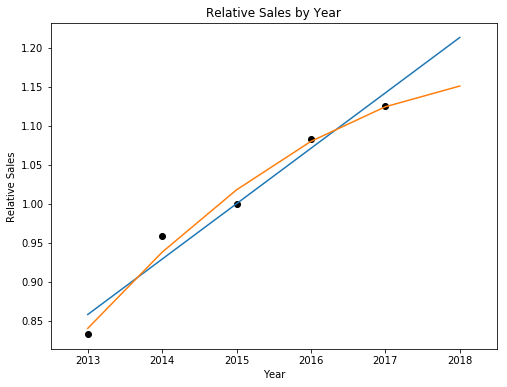

2018 Relative Sales by Degree-1 (Linear) Fit = 1.2132
2018 Relative Sales by Degree-2 (Quadratic) Fit = 1.1509


In [7]:
# Monthly Pattern
month_table = pd.pivot_table(data, index='month', values='sales',
                            aggfunc=np.mean)
month_table.sales /= grand_avg

# Day of Week Pattern
dow_table = pd.pivot_table(data, index='DoW', values='sales',
                          aggfunc=np.mean)
dow_table.sales /= grand_avg

# Yearly Pattern
year_table = pd.pivot_table(data, index='year', values='sales',
                           aggfunc=np.mean)
year_table /= grand_avg

years = np.arange(2013, 2019)
annual_sales_avg = year_table.values.squeeze()

p1 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 1))
p2 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 2))

plt.figure(figsize=(8,6))
plt.plot(years[:-1], annual_sales_avg, 'ko')
plt.plot(years, p1(years), 'C0-')
plt.plot(years, p2(years), 'C1-')
plt.xlim(2012.5, 2018.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.show()

print("2018 Relative Sales by Degree-1 (Linear) Fit = {0:.4f}".format(p1(2018)))
print("2018 Relative Sales by Degree-2 (Quadratic) Fit = {0:.4f}".format(p2(2018)))

# We pick the quadratic fit
annual_growth = p2

We can do a simple linear regression on the yearly growth datapoints.  But if you look carefully, you can tell that the growth is slowing down.  The quadratic fit works better since it better captures the curvature in the growth curve.  Since we only have 5 points, this is the highest degree polynomial fit you should do to avoid overfitting.

Now, we write the predictor.  When we are asked to predict the sales of Item X at Store Y on, say, a Monday in February - all we have to do is look up the historical average of the sales of Item X at Store Y and then multiply it by a factor corresponding to Monday and then a factor corresponding to February to account for the seasonal and weekly changes in item sales at the stores.  Finally, we multiply the annual growth factor for the year we are predicting for.  And thus, we have a very simple forecast of the item's sales.

This predictor will run quite fast and should parse through the whole dataset in less than 20 seconds.  A significant improvement over the "dumb" prediction method both in accuracy and compute efficiency.

In [8]:
def slightly_better(test, submission):
    submission[['sales']] = submission[['sales']].astype(np.float64)
    for _, row in test.iterrows():
        dow, month, year = row.name.dayofweek, row.name.month, row.name.year
        item, store = row['item'], row['store']
        base_sales = store_item_table.at[store, item]
        mul = month_table.at[month, 'sales'] * dow_table.at[dow, 'sales']
        pred_sales = base_sales * mul * annual_growth(year)
        submission.at[row['id'], 'sales'] = pred_sales
    return submission

In [10]:
slightly_better_pred = slightly_better(test, sample.copy())
slightly_better_pred.to_csv("sbp_float.csv", index=False)

# Round to the nearest integer (if you want an integer submission)
sbp_round = slightly_better_pred.copy()
sbp_round['sales'] = np.round(sbp_round['sales']).astype(int)
sbp_round.to_csv("sbp_round.csv", index=False)